<a href="https://colab.research.google.com/github/juunnn/DTSAI2019/blob/master/D21_JunaediFahmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
---


## Step by step CNN by Andrew Ng


In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 1. Define padding to image

In [0]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    ### END CODE HERE ###
    
    return X_pad

x.shape: (4, 3, 3, 2)
x_pad.shape: (4, 7, 7, 2)
x[1,1]: [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


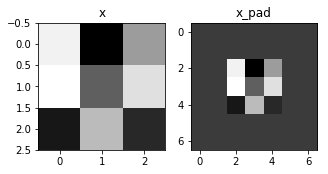

In [0]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x, 2)
print("x.shape:",x.shape)
print("x_pad.shape:", x_pad.shape)
print("x[1,1]:", x[1,1])
print("x_pad[1,1]",x_pad[1,1])

fig, axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### 2. Define Convolution on Single Step

In [0]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)

    return Z

In [0]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


### 3. Define Convolution Forward

In [0]:
def conv_forward(A_prev, W, b, hparams):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f,f,n_C_prev, n_C) = W.shape

    stride = hparams['stride']
    pad = hparams['pad']

    n_H = int( (n_H_prev - f + 2*pad) / stride) + 1
    n_W = int( (n_W_prev - f + 2*pad) / stride) + 1

    Z = np.zeros((m, n_H, n_W, n_C))

    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[1]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    v_start = h * stride
                    v_end = v_start + f
                    h_start = w * stride
                    h_end = h_start + f
                    
                    a_slice_prev = a_prev_pad[v_start:v_end, h_start:h_end,:]

                    Z[i,h,w,c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])

    assert(Z.shape == (m, n_H, n_W, n_C))

    cache = (A_prev,W, b, hparams)

    return Z, cache

In [0]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[1][2][3]", Z[1,2,3])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.10259422788382341
Z[1][2][3] [  3.97577197  -2.90234252  -1.18706955  17.00859655   8.22302755
   3.85652638 -11.20450403   2.16979357]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


### 4. Pooling

In [0]:
def pool_forward(A_prev, hparams, mode="max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparams['f']
    stride = hparams['stride']

    n_H = int(1+ (n_H_prev - f)/stride)
    n_W = int(1 + (n_W_prev - f)/stride)
    n_C = n_C_prev

    A = np.zeros((m,n_H, n_W,n_C))
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    v_start = h*stride
                    v_end = v_start + f
                    h_start = w*stride
                    h_end = h_start + f

                    a_prev_slice = A_prev[i, v_start:v_end, h_start:h_end,c]

                    if mode == "max":
                        A[i,h,w,c] = np.max(a_prev_slice)
                    elif mode=="average":
                        A[i,h,w,c] = np.mean(a_prev_slice)

    assert(A.shape == (m,n_H, n_W, n_C))

    cache = (A_prev, hparams)
    return A, cache

In [0]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


### 5. Backprop Conv

In [0]:
def conv_backward(dZ, cache):
    (A_prev, W, b, hparams) = cache

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape

    stride = hparams['stride']
    pad = hparams['pad']

    (m, n_H, n_W, n_C) = dZ.shape
    dA_prev = np.zeros((m,n_H_prev,n_W_prev, n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    v_start = h * stride
                    v_end = v_start + f
                    h_start = w * stride
                    h_end = h_start + f

                    a_slice = a_prev_pad[v_start:v_end, h_start:h_end,:]

                    da_prev_pad[v_start:v_end, h_start:h_end,:] += W[:,:,:,c] * dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m,n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db


In [0]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))
print(dA.shape)

dA_mean = 18.40098308643454
dW_mean = 1.9595907051782742
db_mean = 50.27117166306732
(10, 4, 4, 3)


#### Create Mask

In [0]:
def create_mask_from_window(x):
    mask = x == np.max(x)

    return mask

In [0]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


#### Distribute Values

In [0]:
def distribute_value(dZ, shape):
    (n_H, n_W) = shape
    average = dZ / (n_H * n_W)

    a = np.ones(shape) * average

    return a

In [0]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


#### Pooling Backwards

In [0]:
def pool_backward(dA, cache, mode="max"):
    (A_prev, hparams) = cache

    stride = hparams['stride']
    f = hparams['f']
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape

    dA_prev = np.zeros(A_prev.shape)

    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    v_start = h
                    v_end = v_start + f
                    h_start = w
                    h_end = h_start + f

                    if mode == 'max':
                        a_prev_slice = a_prev[v_start:v_end, h_start:h_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i,v_start:v_end, h_start:h_end, c] += np.multiply(mask, dA[i,h,w,c])
                    elif mode == 'average':
                        da = dA[i,h,w,c]
                        shape = (f,f)

                        dA_prev[i,v_start:v_end, h_start:h_end, c] = distribute_value(da, shape)

    assert(dA_prev.shape == A_prev.shape)

    return dA_prev


In [0]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[-0.16172917  0.22537172]
 [ 0.63208143 -0.06215869]
 [ 0.63208143 -0.06215869]]


## CNN with KERAS

### Mount drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


### Copy necessery files to current directory

In [0]:
!cp /gdrive/My\ Drive/Day\ 21/datasets -r .
!cp /gdrive/My\ Drive/Day\ 21/kt_utils.py .
!python kt_utils.py
!pip install tensorboardcolab

Using TensorFlow backend.


### Import library

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
https://b71a5e74.ngrok.io


### Load dataset and spliting totrain and test

In [0]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### Definisikan model umum

In [0]:
def model(input_shape):
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')

    return model

### Train and evaluate model

In [0]:
model_1 = model(X_train.shape[1:])
model_1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_1.fit(X_train, Y_train, epochs=40, batch_size=50, callbacks=[TensorBoardColabCallback(tbc)])
preds = model_1.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

W0730 04:51:26.922293 139646030858112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 04:51:26.956733 139646030858112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 04:51:26.975056 139646030858112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 04:51:27.022021 139646030858112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0730 04:51:27.023692 1396460308

Epoch 1/40
600/600 [==============================] - 6s 9ms/step - loss: 1.4297 - acc: 0.6233
Epoch 2/40
600/600 [==============================] - 5s 8ms/step - loss: 0.4308 - acc: 0.8217
Epoch 3/40
600/600 [==============================] - 5s 9ms/step - loss: 0.2536 - acc: 0.9017
Epoch 4/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1473 - acc: 0.9483
Epoch 5/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1210 - acc: 0.9533
Epoch 6/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1057 - acc: 0.9700
Epoch 7/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1073 - acc: 0.9667
Epoch 8/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0945 - acc: 0.9683
Epoch 9/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0692 - acc: 0.9850
Epoch 10/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0528 - acc: 0.9833
Epoch 11/40
600/600 [============================

### Definisikan model happy HOuse

In [0]:
def HappyModel(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model    

In [0]:
happyModel = HappyModel(X_train.shape[1:])

In [0]:
happyModel.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [0]:
happyModel.fit(X_train, Y_train, epochs=40, batch_size=50)

Epoch 1/40
600/600 [==============================] - 5s 9ms/step - loss: 2.1453 - acc: 0.5567
Epoch 2/40
600/600 [==============================] - 5s 8ms/step - loss: 0.3523 - acc: 0.8267
Epoch 3/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1834 - acc: 0.9400
Epoch 4/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1494 - acc: 0.9417
Epoch 5/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1286 - acc: 0.9550
Epoch 6/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0794 - acc: 0.9833
Epoch 7/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0844 - acc: 0.9767
Epoch 8/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0636 - acc: 0.9817
Epoch 9/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0604 - acc: 0.9850
Epoch 10/40
600/600 [==============================] - 5s 9ms/step - loss: 0.0571 - acc: 0.9783
Epoch 11/40
600/600 [============================

In [0]:
preds = happyModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 4ms/step

Loss = 0.07011157194773356
Test Accuracy = 0.9733333373069764


In [0]:
!wget https://pm1.narvii.com/6848/8d46372e7ea193940e0f1b4e7c3203996ef9af58v2_hq.jpg

--2019-07-30 05:03:36--  https://pm1.narvii.com/6848/8d46372e7ea193940e0f1b4e7c3203996ef9af58v2_hq.jpg
Resolving pm1.narvii.com (pm1.narvii.com)... 13.32.80.11, 13.32.80.8, 13.32.80.33, ...
Connecting to pm1.narvii.com (pm1.narvii.com)|13.32.80.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71036 (69K) [image/jpeg]
Saving to: ‘8d46372e7ea193940e0f1b4e7c3203996ef9af58v2_hq.jpg’

8d46372e7ea193940e0 100%[===================>]  69.37K   425KB/s    in 0.2s    

2019-07-30 05:03:36 (425 KB/s) - ‘8d46372e7ea193940e0f1b4e7c3203996ef9af58v2_hq.jpg’ saved [71036/71036]



[[1.]]


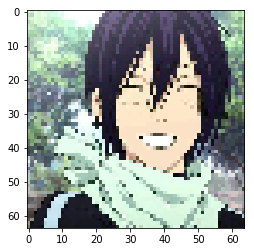

In [0]:
img_path = '8d46372e7ea193940e0f1b4e7c3203996ef9af58v2_hq.jpg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

In [0]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
__________

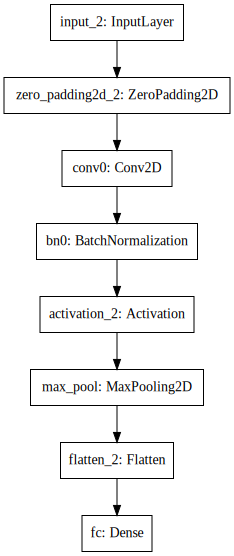

In [0]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))